<a href="https://colab.research.google.com/github/ktbdls/Deep-Learning-Exploration-and-Interpretation-for-Skin-Lesion-Classification/blob/main/InceptionResNet_and_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install for XAI later
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.9 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import itertools
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

In [ ]:
# load previously converted data
data = np.load('/content/drive/MyDrive/DISSERTATION/NEW/ISIC2018_images.npy',mmap_mode='r')
labels = np.load('/content/drive/MyDrive/DISSERTATION/NEW/ISIC2018_labels.npy',mmap_mode='r')

# print to viusualise shape
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (10015, 224, 224, 3)
Labels shape: (10015, 7)


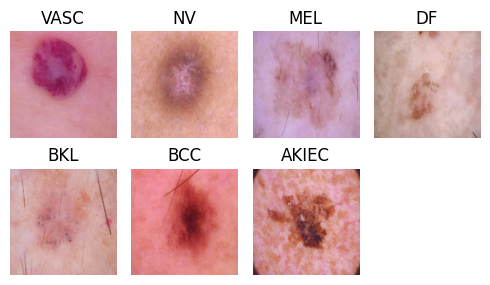

In [ ]:
# gather unique class labels and their corresponding indices in the npy array
unique_classes = np.unique(labels, axis=1)

# create a dictionary to store one data sample from each class
class_samples = {}

# add class indices to their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# select one data sample from each class to display
for class_label in unique_classes:
    class_indices = np.where(np.all(labels == class_label, axis=1))[0]
    class_samples[tuple(class_label)] = data[class_indices[0]]

# show images in 2 rows
plt.figure(figsize=(5, 3))
for i, (class_label, image_data) in enumerate(class_samples.items()):
    class_index = np.argmax(class_label)  # Get the index of the class
    class_name = class_names[class_index]  # Get the corresponding class name
    plt.subplot(2, 4, i + 1)
    plt.imshow(image_data)
    plt.title(f'{class_name}')
    plt.axis('off')

# print to check and visualise
plt.tight_layout()
plt.show()

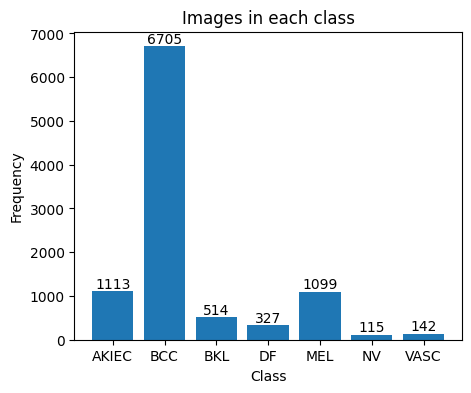

In [ ]:
# sum the one-hot encoded labels across the rows to calculate the frequency of each class
class_counts = np.sum(labels, axis=0)

# associate class indices with their corresponding names
class_names = {0: "AKIEC", 1: "BCC", 2: "BKL", 3: "DF", 4: "MEL", 5: "NV", 6: "VASC"}

# plot the class frequencies for visual analysis of data spread
plt.figure(figsize=(5, 4))
plt.bar([class_names[class_idx] for class_idx in range(len(class_names))], class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Images in each class')

# annotate each bar with their class frequency (in integers)
for i, count in enumerate(class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

In [ ]:
# split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1,stratify=labels, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1,stratify=train_labels, random_state=42)

In [ ]:
# print to check split shapes
print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
print("val_data shape:", val_data.shape)
print("val_labels shape:", val_labels.shape)
print("test_data shape:", test_data.shape)
print("test_labels shape:", test_labels.shape)
# shows split 80/9/11

train_data shape: (8111, 224, 224, 3)
train_labels shape: (8111, 7)
val_data shape: (902, 224, 224, 3)
val_labels shape: (902, 7)
test_data shape: (1002, 224, 224, 3)
test_labels shape: (1002, 7)


In [ ]:
class_names_mapping = {
    0: "AKIEC",
    1: "BCC",
    2: "BKL",
    3: "DF",
    4: "MEL",
    5: "NV",
    6: "VASC"
}
# calculate class distribution of the sets
num_classes = train_labels.shape[1]
class_counts_train = np.sum(train_labels, axis=0)
class_counts_val = np.sum(val_labels, axis=0)
class_counts_test = np.sum(test_labels, axis=0)

class_counts_mapping = {}
for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name] = {'Train': class_counts_train[index]}

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Validation'] = class_counts_val[index]

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Test'] = class_counts_test[index]

# print to visualise for each set
for class_name, counts in class_counts_mapping.items():
    print(class_name)
    for set_name, count in counts.items():
        print(f" - {set_name}: {count}")

# BCC has the highest - highly imbalanced

AKIEC
 - Train: 902.0
 - Validation: 100.0
 - Test: 111.0
BCC
 - Train: 5430.0
 - Validation: 604.0
 - Test: 671.0
BKL
 - Train: 417.0
 - Validation: 46.0
 - Test: 51.0
DF
 - Train: 264.0
 - Validation: 30.0
 - Test: 33.0
MEL
 - Train: 890.0
 - Validation: 99.0
 - Test: 110.0
NV
 - Train: 93.0
 - Validation: 10.0
 - Test: 12.0
VASC
 - Train: 115.0
 - Validation: 13.0
 - Test: 14.0


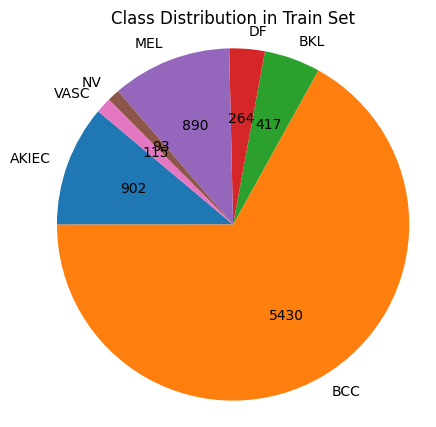

In [ ]:
# make visual pie charts
for set_name in ['Train']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal') # a circle
    plt.show()

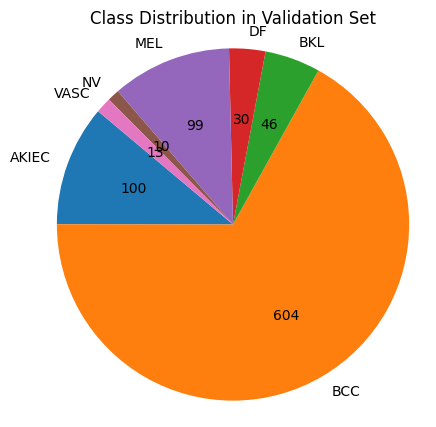

In [ ]:
# make visual pie charts
for set_name in ['Validation']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal') # a circle
    plt.show()

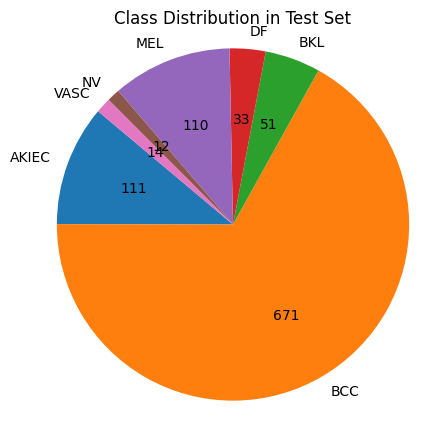

In [ ]:
# make visual pie charts
for set_name in ['Test']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal') # a circle
    plt.show()

In [ ]:
# data augmentation during training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max', min_lr=1e-4, verbose=1)
saved_model = '/content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras'
model_chkpt = ModelCheckpoint(saved_model, save_best_only=True, monitor='val_accuracy', verbose=1)

# list of callbacks
callback_list = [model_chkpt, lr_reduce]

In [ ]:
base_model = InceptionResNetV2(weights='imagenet',
                             include_top=False,
                             input_shape=(224, 224, 3))

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x) # bridge CNN to fully connected layers
x = Dense(128, activation='relu')(x) # relu activation fuction for added layers ontop of CNN - great for learing complex patterns in the image data
x = Dropout(0.5)(x) # prevent overfitting
predictions = Dense(7, activation='softmax')(x)  # 7 classes to output with softmax to put each raw output score into its probable class

# create the final model with custom classification layers
model = Model(inputs=base_model.input, outputs=predictions)


# compile model with adam optimiser
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 50
batch_size = 16

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.6417 - loss: 1.0821
Epoch 1: val_accuracy improved from -inf to 0.67184, saving model to /content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras
507/507 ━━━━━━━━━━━━━━━━━━━━ 366s 392ms/step - accuracy: 0.6418 - loss: 1.0819 - val_accuracy: 0.6718 - val_loss: 93.6674 - learning_rate: 0.0010
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6944 - loss: 0.8927
Epoch 2: val_accuracy improved from 0.67184 to 0.70732, saving model to /content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras
507/507 ━━━━━━━━━━━━━━━━━━━━ 92s 179ms/step - accuracy: 0.6944 - loss: 0.8926 - val_accuracy: 0.7073 - val_loss: 1.0037 - learning_rate: 0.0010
Epoch 3/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7058 - loss: 0.8119
Epoch 3: val_accuracy did not improve from 0.70732
507/507 ━━━━━━━━━━━━━━━━━━━━ 85s 164ms/step - accuracy: 0.7058 - loss: 0.8119 - val_accuracy: 0.6441 - val_loss: 0.8668 - learning_ra

In [ ]:
model= load_model('/content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras')

In [ ]:
epochs = 10

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.8841 - loss: 0.3342
Epoch 1: val_accuracy did not improve from 0.83814
507/507 ━━━━━━━━━━━━━━━━━━━━ 295s 317ms/step - accuracy: 0.8841 - loss: 0.3342 - val_accuracy: 0.8226 - val_loss: 0.6285 - learning_rate: 2.5000e-04
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8814 - loss: 0.3212
Epoch 2: val_accuracy did not improve from 0.83814
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 160ms/step - accuracy: 0.8814 - loss: 0.3212 - val_accuracy: 0.7960 - val_loss: 0.9461 - learning_rate: 2.5000e-04
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8778 - loss: 0.3301
Epoch 3: val_accuracy did not improve from 0.83814
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.8778 - loss: 0.3301 - val_accuracy: 0.8215 - val_loss: 0.6531 - learning_rate: 2.5000e-04
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8832 - loss: 0.3010
Epoch 4: val_accuracy did not improve from 0.83814

In [ ]:
model= load_model('/content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras')

In [ ]:
epochs = 5

In [ ]:
history = model.fit(datagen.flow(train_data, train_labels, batch_size=batch_size),
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list)

Epoch 1/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8795 - loss: 0.3235
Epoch 1: val_accuracy did not improve from 0.83814
507/507 ━━━━━━━━━━━━━━━━━━━━ 294s 315ms/step - accuracy: 0.8795 - loss: 0.3235 - val_accuracy: 0.8348 - val_loss: 0.5086 - learning_rate: 2.5000e-04
Epoch 2/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8822 - loss: 0.3164
Epoch 2: val_accuracy did not improve from 0.83814
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.8822 - loss: 0.3164 - val_accuracy: 0.8204 - val_loss: 0.6445 - learning_rate: 2.5000e-04
Epoch 3/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8864 - loss: 0.3155
Epoch 3: val_accuracy did not improve from 0.83814
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.8864 - loss: 0.3155 - val_accuracy: 0.8060 - val_loss: 0.6646 - learning_rate: 2.5000e-04
Epoch 4/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8910 - loss: 0.3073
Epoch 4: val_accuracy did not improve from 0.83814
507

In [ ]:
model= load_model('/content/drive/MyDrive/DISSERTATION/NEW/SavedModel/Xception.keras')

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 331ms/step - accuracy: 0.8188 - loss: 0.5490
Test Accuracy: 0.8153692483901978


In [ ]:
# use test data to get predictions
predictions = model.predict(test_data)

# convert preds to int values
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# gather report
report = classification_report(true_labels, predicted_labels)

# print for visual
print("Classification Report:")
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.59      0.55       111
           1       0.93      0.89      0.91       671
           2       0.79      0.67      0.72        51
           3       0.86      0.55      0.67        33
           4       0.57      0.75      0.65       110
           5       0.88      0.58      0.70        12
           6       0.73      0.79      0.76        14

    accuracy                           0.82      1002
   macro avg       0.75      0.69      0.71      1002
weighted avg       0.83      0.82      0.82      1002



In [ ]:
# confusion matrix
cm = confusion_matrix(true_labels, np.round(predicted_labels))

cm

array([[ 65,  25,   2,   0,  19,   0,   0],
       [ 38, 600,   3,   0,  26,   1,   3],
       [  3,   5,  34,   2,   6,   0,   1],
       [  5,   3,   1,  18,   6,   0,   0],
       [ 11,  13,   3,   1,  82,   0,   0],
       [  1,   0,   0,   0,   4,   7,   0],
       [  1,   2,   0,   0,   0,   0,  11]])

Normalized confusion matrix


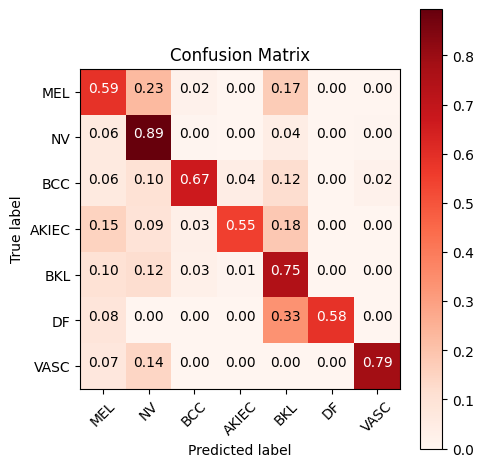

In [ ]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


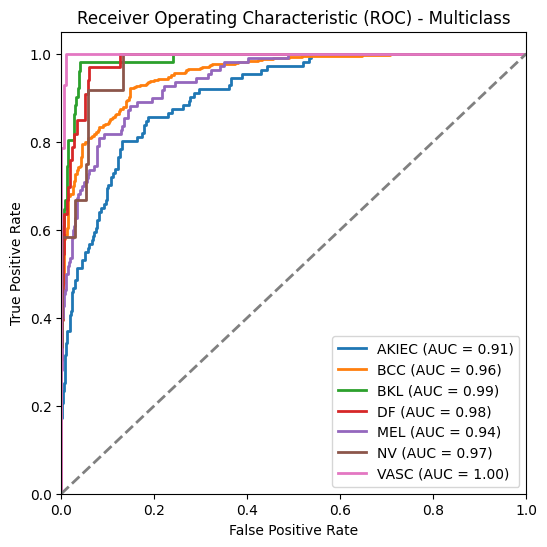

In [ ]:
# list of defined class names
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# predictions from test data
predictions = model.predict(test_data)

# no. of classes
num_classes = test_labels.shape[1]

# figure features
plt.figure(figsize=(6, 6))

# going through each of the classes
for class_index in range(num_classes):
    # calc ROC curve and ROC AUC for the specific class
    fpr, tpr, thresholds = roc_curve(test_labels[:, class_index], predictions[:, class_index])
    roc_auc = auc(fpr, tpr)

    # plot it
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[class_index]} (AUC = {roc_auc:.2f})')

# plot diagonal line to see if the model is performing better than "random"
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# graph properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc='lower right')

plt.show()

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow.python.client import device_lib
device_list = device_lib.list_local_devices()
gpus = [device.name for device in device_list if device.device_type == 'GPU']
print('TensorFlow recognized {} GPUs'.format(len(gpus)))

TensorFlow recognized 1 GPUs


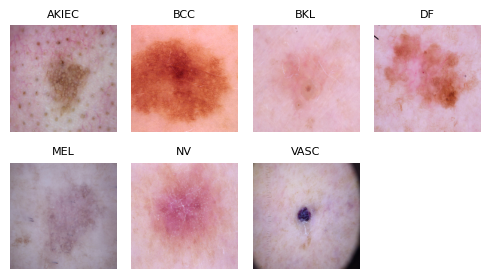

In [ ]:
image_titles = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_images = len(image_titles)

# convert to integer labels
test_labels_int = np.argmax(test_labels, axis=1)
# find the indices of the first image from each class
class_indices = [np.where(test_labels_int == i)[0][0] for i in range(len(image_titles))]

# store the images
image_array = []

# subplots with 2 rows
num_rows = 2
num_cols = (num_images + 1) // num_rows
fig, ax = plt.subplots(num_rows, num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols
    ax[row, col].set_title(title, fontsize=8)

    # predicted images test data
    img = test_data[class_indices[i]]
    image_array.append(img)  # add to store

    ax[row, col].imshow(img)
    ax[row, col].axis('off')

# dispose of empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

X = base_preprocess(np.array(image_array))

X = base_preprocess(np.array(image_array))

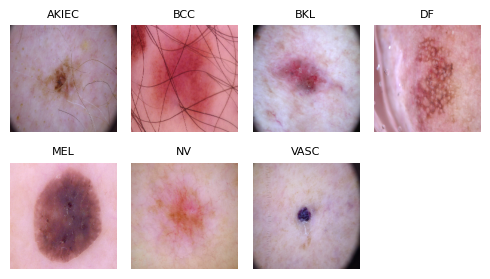

In [ ]:
image_titles = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_images = len(image_titles)

# convert to integer labels
test_labels_int = np.argmax(test_labels, axis=1)
# store the images
image_array = []

# subplots with 2 rows
num_rows = 2
num_cols = (num_images + 1) // num_rows
fig, ax = plt.subplots(num_rows, num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols
    ax[row, col].set_title(title, fontsize=8)

    # find indices of images for specific class
    class_indices = np.where(test_labels_int == i)[0]
    random_index = np.random.choice(class_indices)  # define random index

    # predicted images test data
    img = test_data[random_index]
    image_array.append(img)  # store

    ax[row, col].imshow(img)
    ax[row, col].axis('off')

# dispose of empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

X = base_preprocess(np.array(image_array))

In [ ]:
replace2linear = ReplaceToLinear()

In [ ]:
score = CategoricalScore([0, 1, 2, 3, 4, 5, 6])

***Saliency maps***

---



---



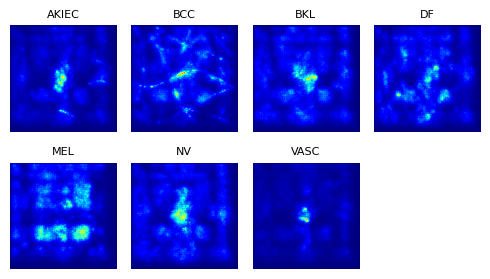

CPU times: user 30.4 s, sys: 472 ms, total: 30.9 s
Wall time: 30.9 s


In [ ]:
%%time
from keras import backend as K
from tf_keras_vis.saliency import Saliency

# create saliency
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# create map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # no. of calculating gradients iterations
                        smooth_noise=0.20) # how much the noise is spread

# subplot features
num_rows = 2
num_cols = (num_images + 1) // num_rows

# rendering
f, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols

    ax[row, col].set_title(title, fontsize=8)
    ax[row, col].imshow(saliency_map[i], cmap='jet')
    ax[row, col].axis('off')

# dispose of empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    f.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

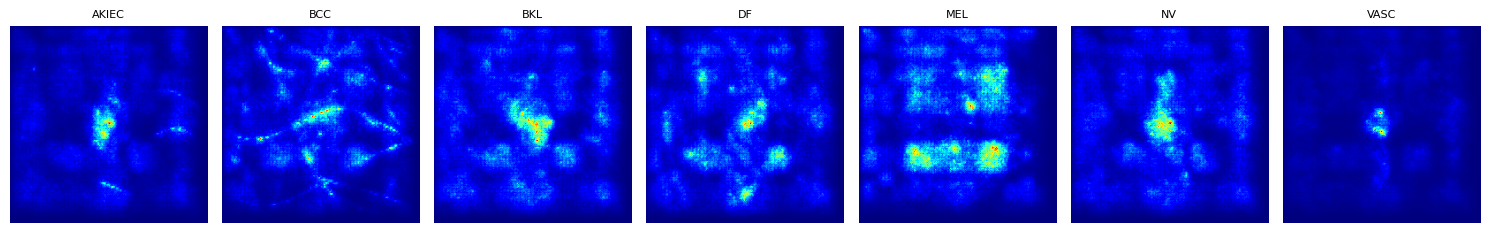

CPU times: user 25.8 s, sys: 406 ms, total: 26.2 s
Wall time: 25.7 s


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# create saliency
saliency = Saliency(model, model_modifier=replace2linear, clone=True)

# create map with smoothing that reduce noise by adding noise
saliency_maps = saliency(score, X, smooth_samples=20, smooth_noise=0.20)

# no. of images
num_images = len(image_titles)

# one row instead of 2 this time
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    axes[i].set_title(title, fontsize=8)
    axes[i].imshow(saliency_maps[i], cmap='jet')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

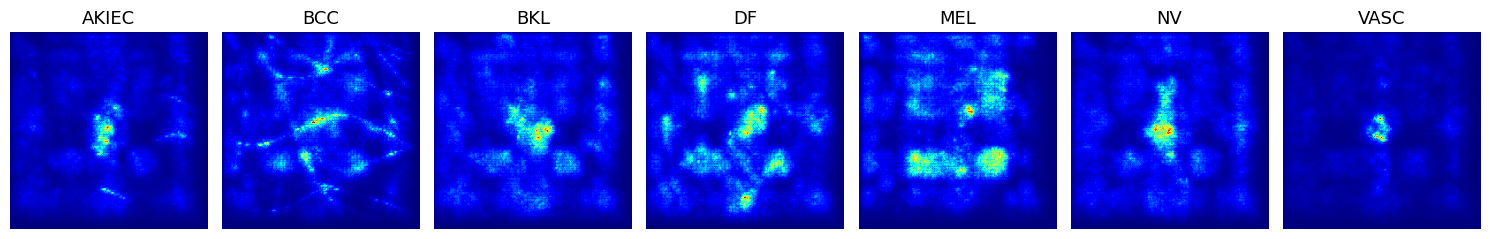

CPU times: user 25.4 s, sys: 415 ms, total: 25.8 s
Wall time: 25.3 s


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# create saliency
saliency = Saliency(model, model_modifier=replace2linear, clone=True)

# create map with smoothing that reduce noise by adding noise
saliency_maps = saliency(score,
                         X,
                         smooth_samples=20,
                         smooth_noise=0.20)

# no. of images
num_images = len(image_titles)

# one row
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, title in enumerate(image_titles):
    axes[i].set_title(title, fontsize=13)
    axes[i].imshow(saliency_maps[i], cmap='jet')
    axes[i].axis('off')

plt.tight_layout()
plt.show()



---



---




In [ ]:
# model.summary()

# # Alternatively, to print only convolutional layers:
# for layer in model.layers:
#     if 'conv' in layer.name:
#         print(layer.name)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 163,482,039 (623.63 MB)

 Trainable params: 54,473,831 (207.80 MB)

 Non-trainable params: 60,544 (236.50 KB)

 Optimizer params: 108,947,664 (415.60 MB)

conv2d
conv2d_1
conv2d_2
conv2d_3
conv2d_4
conv2d_8
conv2d_6
conv2d_9
conv2d_5
conv2d_7
conv2d_10
conv2d_11
conv2d_15
conv2d_13
conv2d_16
conv2d_12
conv2d_14
conv2d_17
block35_1_conv
conv2d_21
conv2d_19
conv2d_22
conv2d_18
conv2d_20
conv2d_23
block35_2_conv
conv2d_27
conv2d_25
conv2d_28
conv2d_24
conv2d_26
conv2d_29
block35_3_conv
conv2d_33
conv2d_31
conv2d_34
conv2d_30
conv2d_32
conv2d_35
block35_4_conv
conv2d_39
conv2d_37
conv2d_40
conv2d_36
conv2d_38
conv2d_41
block35_5_conv
conv2d_45
conv2d_43
conv2d_46
conv2d_42
conv2d_44
conv2d_47
block35_6_conv
conv2d_51
conv2d_49
conv2d_52
conv2d_48
conv2d_50
conv2d_53
block35_7_conv
conv2d_57
conv2d_55
conv2d_58
conv2d_54
conv2d_56
conv2d_59
block35_8_conv
conv2d_63
conv2d_61
conv2d_64
conv2d_60
conv2d_62
conv2d_65
block35_9_conv
conv2d_69
conv2d_67
conv2d_70
conv2d_66
conv2d_68
conv2d_71
block35_10_conv
conv2d_73
conv2d_74
conv2d_72
conv2d_75
conv2d_77
conv2d_78
conv2d_76
conv2d_79
block17_1_conv
conv2d_81
conv2d_82
conv2d_80
conv2d_83
block1

In [ ]:
# # Get model's prediction confidence for all images
# model_output = model.predict(X)

# # Print out the confidence for each class for each image
# for i, prediction in enumerate(model_output):
#     print(f"Image {i}: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Image 0: [9.9976748e-01 2.2863480e-04 2.8466308e-13 6.9565634e-12 3.9657539e-06
 9.9393573e-13 2.0575157e-10]
Image 1: [9.9979448e-01 2.0175418e-04 2.5124886e-13 6.3794556e-12 3.7157456e-06
 8.6579610e-13 1.6932029e-10]
Image 2: [9.9974281e-01 2.5301921e-04 3.1994790e-13 7.5018091e-12 4.1827952e-06
 1.1256133e-12 2.4564353e-10]
Image 3: [9.9976248e-01 2.3353293e-04 2.9206271e-13 7.0931655e-12 4.0110767e-06
 1.0220057e-12 2.1325168e-10]
Image 4: [9.9975175e-01 2.4421551e-04 3.0846931e-13 7.3454758e-12 4.1083740e-06
 1.0846176e-12 2.3273911e-10]
Image 5: [9.9974710e-01 2.4868647e-04 3.1632252e-13 7.4678068e-12 4.1571707e-06
 1.1114714e-12 2.3962354e-10]
Image 6: [9.9975330e-01 2.4264700e-04 3.0177561e-13 7.1840251e-12 4.0758559e-06
 1.0594497e-12 2.2721930e-10]


In [ ]:
# # Check the model's predictions for the input images
# model_output = model.predict(X)

# # Print the confidence for each class for each image
# for i, prediction in enumerate(model_output):
#     print(f"Image {i} Predictions: {prediction}")
#     print(f"Class with max confidence: {np.argmax(prediction)}")

# # Get the distribution of predicted classes
# predicted_classes = np.argmax(model_output, axis=1)
# unique, counts = np.unique(predicted_classes, return_counts=True)
# class_distribution = dict(zip(unique, counts))

# print(f"Predicted class distribution: {class_distribution}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image 0 Predictions: [9.9976748e-01 2.2863480e-04 2.8466308e-13 6.9565634e-12 3.9657539e-06
 9.9393573e-13 2.0575157e-10]
Class with max confidence: 0
Image 1 Predictions: [9.9979448e-01 2.0175418e-04 2.5124886e-13 6.3794556e-12 3.7157456e-06
 8.6579610e-13 1.6932029e-10]
Class with max confidence: 0
Image 2 Predictions: [9.9974281e-01 2.5301921e-04 3.1994790e-13 7.5018091e-12 4.1827952e-06
 1.1256133e-12 2.4564353e-10]
Class with max confidence: 0
Image 3 Predictions: [9.9976248e-01 2.3353293e-04 2.9206271e-13 7.0931655e-12 4.0110767e-06
 1.0220057e-12 2.1325168e-10]
Class with max confidence: 0
Image 4 Predictions: [9.9975175e-01 2.4421551e-04 3.0846931e-13 7.3454758e-12 4.1083740e-06
 1.0846176e-12 2.3273911e-10]
Class with max confidence: 0
Image 5 Predictions: [9.9974710e-01 2.4868647e-04 3.1632252e-13 7.4678068e-12 4.1571707e-06
 1.1114714e-12 2.3962354e-10]
Class with max confidence: 0
Image 6 Predictions: [9.9975330e-01 2.4264700e-04 3.0177

In [ ]:
# # Assuming `y_train` contains your training labels
# unique, counts = np.unique(train_labels, return_counts=True)
# class_distribution = dict(zip(unique, counts))

# print(f"Training set class distribution: {class_distribution}")

Training set class distribution: {0.0: 48666, 1.0: 8111}


***XAI models***

---



---



3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step


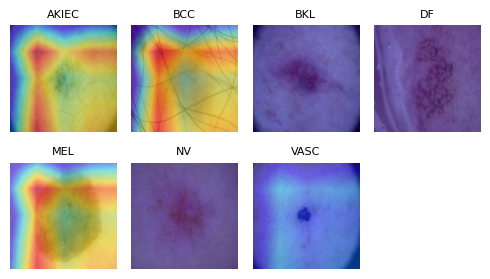

CPU times: user 24.3 s, sys: 788 ms, total: 25 s
Wall time: 24.3 s


In [ ]:
#FASTER SCORECAM

%%time
from matplotlib import cm
from tf_keras_vis.scorecam import Scorecam

# create scorecam variable
scorecam = Scorecam(model, model_modifier=replace2linear)

# implement faster scorecam parameters
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

# subplot features
num_rows = 2
num_cols = (num_images + 1) // num_rows

# rendering
f, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5, 3))

for i, title in enumerate(image_titles):
    row = i // num_cols
    col = i % num_cols

    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[row, col].set_title(title, fontsize=8)
    ax[row, col].imshow(image_array[i])
    ax[row, col].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[row, col].axis('off')

# dispose of empty subplots
for i in range(len(image_titles), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    f.delaxes(ax[row, col])

plt.tight_layout()
plt.show()

In [ ]:
# %%time
# from matplotlib import pyplot as plt, cm
# from tf_keras_vis.scorecam import Scorecam

# # Assuming you have already defined model and replace2linear

# # Create ScoreCAM object
# scorecam = Scorecam(model, model_modifier=replace2linear)

# # Generate heatmaps with Faster-ScoreCAM
# cam = scorecam(score, X, penultimate_layer=-1, max_N=10)

# # Calculate the number of images
# num_images = len(image_titles)

# # Create a single row plot
# fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# for i, title in enumerate(image_titles):
#     heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

#     combined_image = cv2.addWeighted(image_array[i], 0.5, heatmap, 0.5, 0)

#     axes[i].set_title(title, fontsize=8)
#     axes[i].imshow(combined_image)
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

1/3 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step


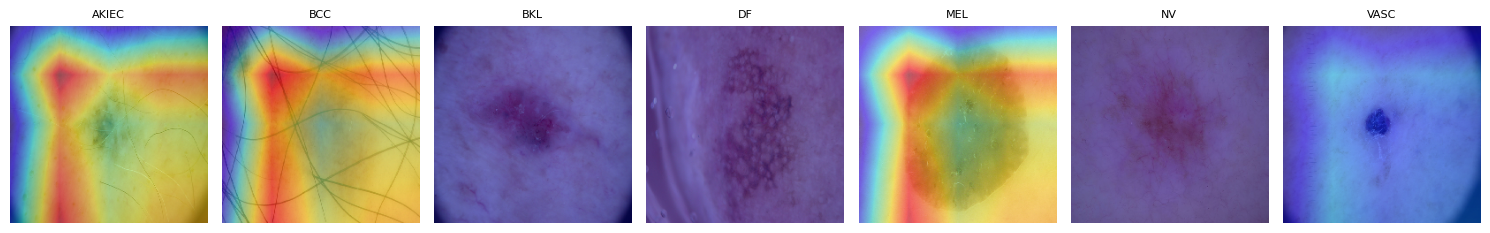

CPU times: user 24.5 s, sys: 1.01 s, total: 25.5 s
Wall time: 24.4 s


In [ ]:
# %%time
# from matplotlib import pyplot as plt, cm
# from tf_keras_vis.scorecam import Scorecam
# import cv2
# import numpy as np

# # Assuming you have already defined model and replace2linear

# # Create ScoreCAM object
# scorecam = Scorecam(model, model_modifier=replace2linear)

# # Generate heatmaps with Faster-ScoreCAM
# cam = scorecam(score, X, penultimate_layer=-1, max_N=10)

# # Calculate the number of images
# num_images = len(image_titles)

# # Create a single row plot
# fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# for i, title in enumerate(image_titles):
#     heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

#     # Convert image_array[i] to uint8 to match heatmap data type.
#     image = np.uint8(image_array[i] * 255)

#     combined_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

#     axes[i].set_title(title, fontsize=8)
#     axes[i].imshow(combined_image)
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
# #GRADCAM

# %%time
# from matplotlib import pyplot as plt, cm
# from tf_keras_vis.gradcam import Gradcam
# import cv2
# import numpy as np

# # Assuming you have already defined model and replace2linear

# # Create GradCAM object
# gradcam = Gradcam(model, model_modifier=replace2linear)

# # Generate heatmaps with GradCAM
# cam = gradcam(score, X, penultimate_layer=-1)

# # Calculate the number of images
# num_images = len(image_titles)

# # Create a single row plot
# fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# for i, title in enumerate(image_titles):
#     heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

#     # Convert image_array[i] to uint8 to match heatmap data type.
#     image = np.uint8(image_array[i] * 255)

#     combined_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

#     axes[i].set_title(title, fontsize=8)
#     axes[i].imshow(combined_image)
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
# #GRADCAM++

# %%time
# from matplotlib import pyplot as plt, cm
# from tf_keras_vis.gradcam import GradcamPlusPlus
# import cv2
# import numpy as np

# # Assuming you have already defined `model` and `replace2linear`

# # Create GradCAM++ object
# gradcam_plus_plus = GradcamPlusPlus(model, model_modifier=replace2linear)

# # Generate heatmaps with Grad-CAM++
# cam = gradcam_plus_plus(score, X, penultimate_layer=-1)

# # Calculate the number of images
# num_images = len(image_titles)

# # Create a single row plot
# fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# for i, title in enumerate(image_titles):
#     heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

#     # Convert image_array[i] to uint8 to match heatmap data type.
#     image = np.uint8(image_array[i] * 255)

#     # Blend the original image with the heatmap
#     combined_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

#     axes[i].set_title(title, fontsize=8)
#     axes[i].imshow(combined_image)
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()




---



---

